In [19]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
from cmocean import cm
import xgcm
import cartopy.feature as cfeature
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [20]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(17)

In [21]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [22]:
client

<Client: scheduler='tcp://10.148.1.32:53239' processes=34 cores=136>

In [24]:
data_dir = '/home1/scratch/xyu/mit_zarr/UV/LLC4320/'

SSU = xr.open_zarr(data_dir+'SSU_f01.zarr')
SSV = xr.open_zarr(data_dir+'SSV_f01.zarr')
mgrid = xr.open_dataset('/home1/datawork/xyu/grid/mit_grid.nc', decode_coords=True)
ds = xr.merge([SSU, SSV, mgrid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 8640)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(8640,)>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (face, j, i) float32 ...
    YC       (face, j, i) float32 ...
    XG       (face, j_g, i_g) float32 ...
    YG       (face, j_g, i_g) float32 ...
    CS       (face, j, i) float32 ...
    SN       (face, j, i) float32 ...
    rA       (face, j, i) float32 ...
    dxG      (face, j_g, i) float32 ...
    dyG      (face, j, i_g) float32 ...
    De

In [25]:
#import xgcm
grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid

<xgcm.Grid>
X Axis (periodic):
  * center   i (4320) --> left
  * left     i_g (4320) --> center
Y Axis (periodic):
  * center   j (4320) --> left
  * left     j_g (4320) --> center

In [28]:
KE = grid.interp(ds['SSU'] * ds['SSU'],'X') + grid.interp(ds['SSV'] * ds['SSV'],'Y')
KE = KE.chunk({'i': 4320, 'j':4320})
KE_tmean = KE.mean(dim='time')
KE_tmean = np.real(KE_tmean).rename('KE_tmean')
KE_tmean = xr.merge([KE_tmean, mgrid])
file_E = data_dir+'KE_tmean_4320_all.zarr'
%time KE_tmean.to_zarr(file_E, mode='w')  

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 9min 29s, sys: 41 s, total: 10min 10s
Wall time: 17min 42s


_________
# 1. Read dataset


In [16]:
data_dir = '/home1/scratch/xyu/mit_zarr/UV/LLC4320_t/'

SSU = xr.concat([xr.open_zarr(data_dir+'SSU_t%04d.zarr'%time) for time in range(720)], dim='time', compat='equals')
SSV = xr.concat([xr.open_zarr(data_dir+'SSV_t%04d.zarr'%time) for time in range(720)], dim='time', compat='equals')
mgrid = xr.open_dataset('/home1/datawork/xyu/grid/mit_grid_t.nc', decode_coords=True)
ds = xr.merge([SSU, SSV, mgrid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 720)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    dtime    (time) datetime64[ns] dask.array<shape=(720,), chunksize=(1,)>
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (face, i, j) float32 ...
    YC       (face, i, j) float32 ...
    XG       (face, i_g, j_g) float32 ...
    YG       (face, i_g, j_g) float32 ...
    CS       (face, i, j) float32 ...
    SN       (face, i, j) float32 ...
    rA       (face, i, j) float32 ...
    dxG      (face, i, j_g) float32 ...
    dyG      (face, j, i_g) float32 ...
    Depth  

In [7]:
#import xgcm
grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid

<xgcm.Grid>
X Axis (periodic):
  * center   i (4320) --> left
  * left     i_g (4320) --> center
Y Axis (periodic):
  * center   j (4320) --> left
  * left     j_g (4320) --> center

In [8]:
KE = grid.interp(ds['SSU'] * ds['SSU'],'X') + grid.interp(ds['SSV'] * ds['SSV'],'Y')
KE = KE.chunk({'i': 4320, 'j':4320})
KE_tmean = KE.mean(dim='time')
KE_tmean = np.real(KE_tmean).rename('KE_tmean')
KE_tmean = xr.merge([KE_tmean, mgrid])
file_E = data_dir+'KE_tmean_4320_120.zarr'
%time KE_tmean.to_zarr(file_E, mode='w')  

CPU times: user 1min 17s, sys: 17.9 s, total: 1min 35s
Wall time: 12min 14s


_______
# 2. Load dataset

In [29]:
data_dir = '/home1/scratch/xyu/mit_zarr/UV/LLC4320/'

mKE = xr.open_zarr(data_dir+'KE_tmean_4320_all.zarr') 
KE_tmean = mKE.KE_tmean
KE_tmean

<xarray.DataArray 'KE_tmean' (j: 4320, i: 4320)>
dask.array<shape=(4320, 4320), dtype=float32, chunksize=(4320, 4320)>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...

In [31]:
mgrid = xr.open_dataset('/home1/datawork/xyu/grid/mit_grid.nc', decode_coords=True)
grid_face = mgrid.isel(face=1)
print(grid_face)

<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face     int64 1
    XC       (j, i) float32 ...
    YC       (j, i) float32 ...
    XG       (j_g, i_g) float32 ...
    YG       (j_g, i_g) float32 ...
    CS       (j, i) float32 ...
    SN       (j, i) float32 ...
    rA       (j, i) float32 ...
    dxG      (j_g, i) float32 ...
    dyG      (j, i_g) float32 ...
    Depth    (j, i) float32 ...
    rAz      (j_g, i_g) float32 ...
    dxC      (j, i_g) float32 ...
    dyC      (j_g, i) float32 ...
    rAw      (j, i_g) float32 ...
    rAs      (j_g, i) float32 ...
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    titl

In [32]:
KE_tmean = xr.merge([KE_tmean, grid_face])
print(KE_tmean)

<xarray.Dataset>
Dimensions:   (i: 4320, i_g: 4320, j: 4320, j_g: 4320)
Coordinates:
  * i         (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face      int64 1
    XC        (j, i) float32 ...
    YC        (j, i) float32 ...
    XG        (j_g, i_g) float32 ...
    YG        (j_g, i_g) float32 ...
    CS        (j, i) float32 ...
    SN        (j, i) float32 ...
    rA        (j, i) float32 ...
    dxG       (j_g, i) float32 ...
    dyG       (j, i_g) float32 ...
    Depth     (j, i) float32 ...
    rAz       (j_g, i_g) float32 ...
    dxC       (j, i_g) float32 ...
    dyC       (j_g, i) float32 ...
    rAw       (j, i_g) float32 ...
    rAs       (j_g, i) float32 ...
Data variables:
    KE_tmean  (j, i) float32 dask.ar

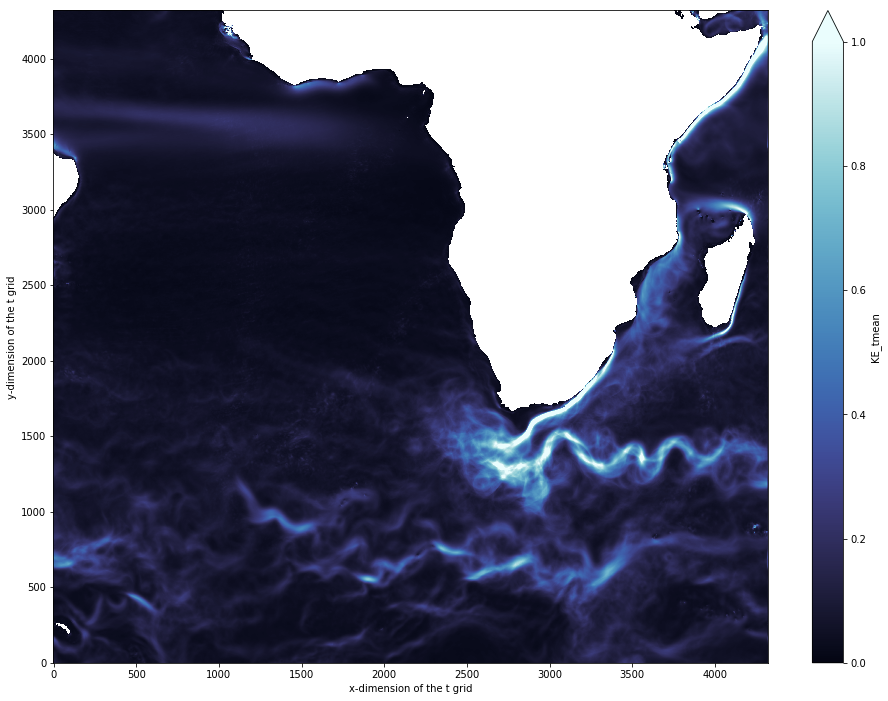

In [34]:
fig = plt.figure(figsize = (16,12))
mKE.KE_tmean.plot(vmin=0, vmax=1, cmap = cm.ice)

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
mKE.KE_tmean.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=1, cmap = cm.ice)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

In [12]:
ds_subset = (KE_tmean.stack(point=['face','j', 'i']).chunk({'point': 100000}))
print(ds_subset)
print('\n data size: %.1f GB' %(ds_subset.nbytes / 1e9))

<xarray.DataArray 'KE_tmean' (point: 242611200)>
dask.array<shape=(242611200,), dtype=float32, chunksize=(100000,)>
Coordinates:
    CS       (point) float32 dask.array<shape=(242611200,), chunksize=(100000,)>
    Depth    (point) float32 dask.array<shape=(242611200,), chunksize=(100000,)>
    SN       (point) float32 dask.array<shape=(242611200,), chunksize=(100000,)>
    XC       (point) float32 dask.array<shape=(242611200,), chunksize=(100000,)>
    YC       (point) float32 dask.array<shape=(242611200,), chunksize=(100000,)>
    rA       (point) float32 dask.array<shape=(242611200,), chunksize=(100000,)>
  * point    (point) MultiIndex
  - face     (point) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
  - j        (point) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
  - i        (point) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

 data size: 1.0 GB


In [13]:
E_KE_zonmean = (ds_subset.where(ds_subset.Depth>500).groupby_bins(ds_subset['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))
E_KE_zonmean= E_KE_zonmean.chunk({'YC_bins': 1})
E_KE_zonmean = np.real(E_KE_zonmean).rename('E_KE_zonmean')
file_E = data_dir+'E_KE_zonmean_120.zarr'
%time E_KE_zonmean.to_dataset().to_zarr(file_E, mode='w')

CPU times: user 1min 3s, sys: 4.1 s, total: 1min 7s
Wall time: 1min 9s


In [14]:
data_dir = '/home1/scratch/xyu/mit_zarr/UV/LLC4320_t/'

ds = xr.open_zarr(data_dir+'E_KE_zonmean_120.zarr') 
print(ds)

<xarray.Dataset>
Dimensions:       (YC_bins: 121)
Coordinates:
  * YC_bins       (YC_bins) int64 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51 ...
Data variables:
    E_KE_zonmean  (YC_bins) float32 dask.array<shape=(121,), chunksize=(1,)>


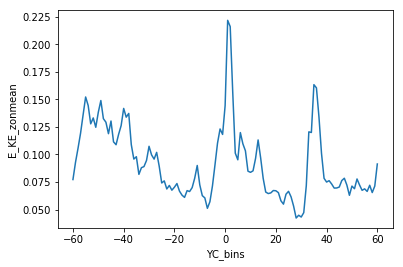

In [15]:
ds.E_KE_zonmean.plot()

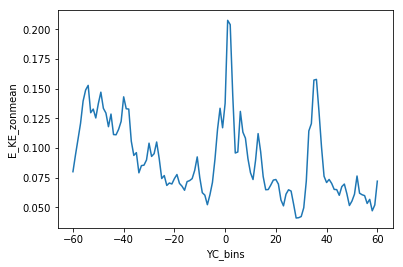

In [14]:
ds.E_KE_zonmean.plot()

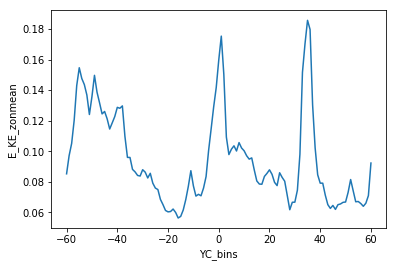

In [13]:
ds.E_KE_zonmean.plot()

______
# 3. Figures

In [33]:
def quick_llc_plot(data, axis_off=False, **kwargs):
    face_to_axis = {0: (2, 0), 1: (1, 0), 2: (0, 0),
                    3: (2, 1), 4: (1, 1), 5: (0, 1),
                    7: (0, 2), 8: (1, 2), 9: (2, 2),
                    10: (0, 3), 11: (1, 3), 12: (2, 3)}
    transpose = [7, 8, 9, 10, 11, 12]
    gridspec_kw = dict(left=0, bottom=0, right=4, top=4, wspace=0, hspace=0)
    fig, axes = plt.subplots(nrows=3, ncols=4, gridspec_kw=gridspec_kw)
    for face, (j, i) in face_to_axis.items():
        data_ax = data.isel(face=face)
        ax = axes[j,i]
        yincrease = True
        if face in transpose:
            data_ax = data_ax.transpose()
            yincrease = False
        data_ax.plot(ax=ax, yincrease=yincrease, **kwargs)
        if axis_off:
            ax.axis('off')
        ax.set_title('')

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.32:34902 remote=tcp://10.148.1.32:45435>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.32:34903 remote=tcp://10.148.1.32:45435>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.32:34904 remote=tcp://10.148.1.32:45435>


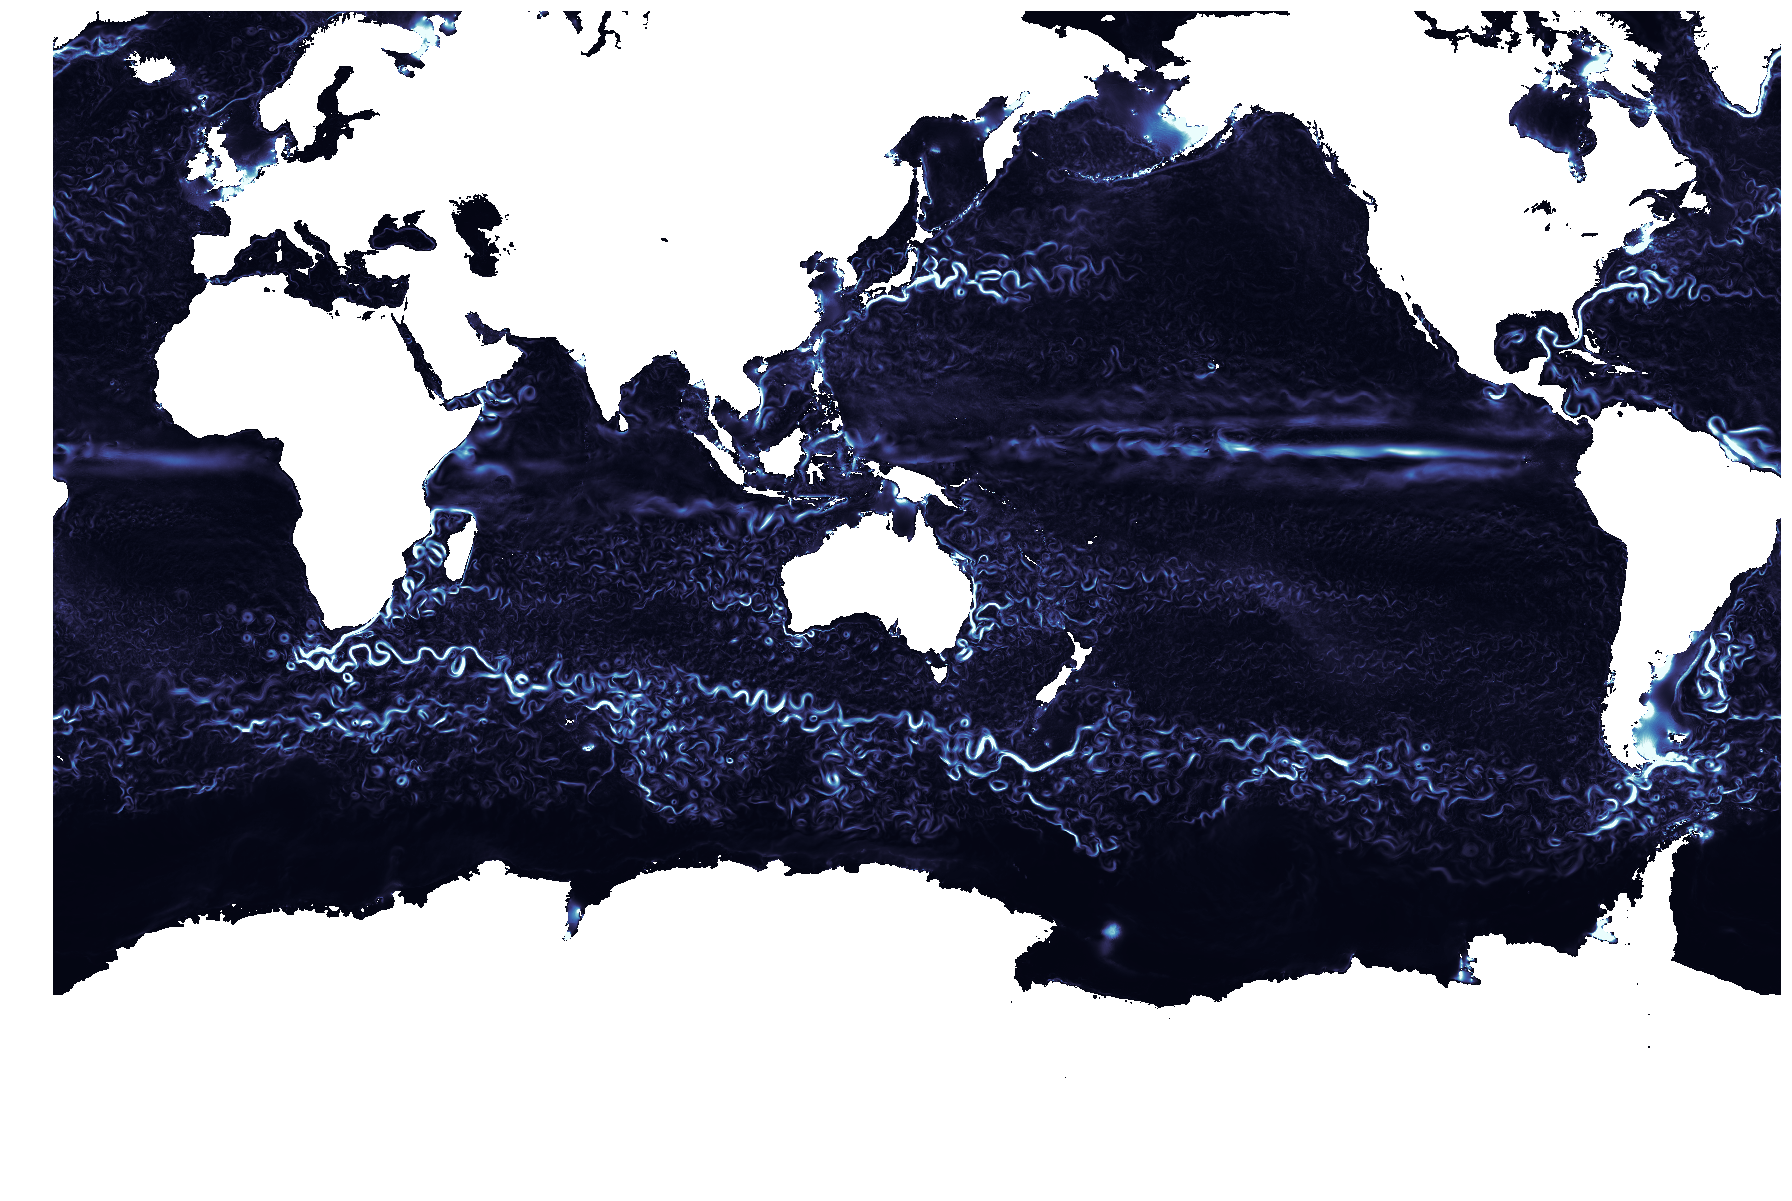

In [11]:
quick_llc_plot(KE_tmean, vmin=0, vmax=1, add_colorbar=False, axis_off=True, cmap = cm.ice)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.10:52830 remote=tcp://10.148.1.10:43165>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.10:52831 remote=tcp://10.148.1.10:43165>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.10:52832 remote=tcp://10.148.1.10:43165>


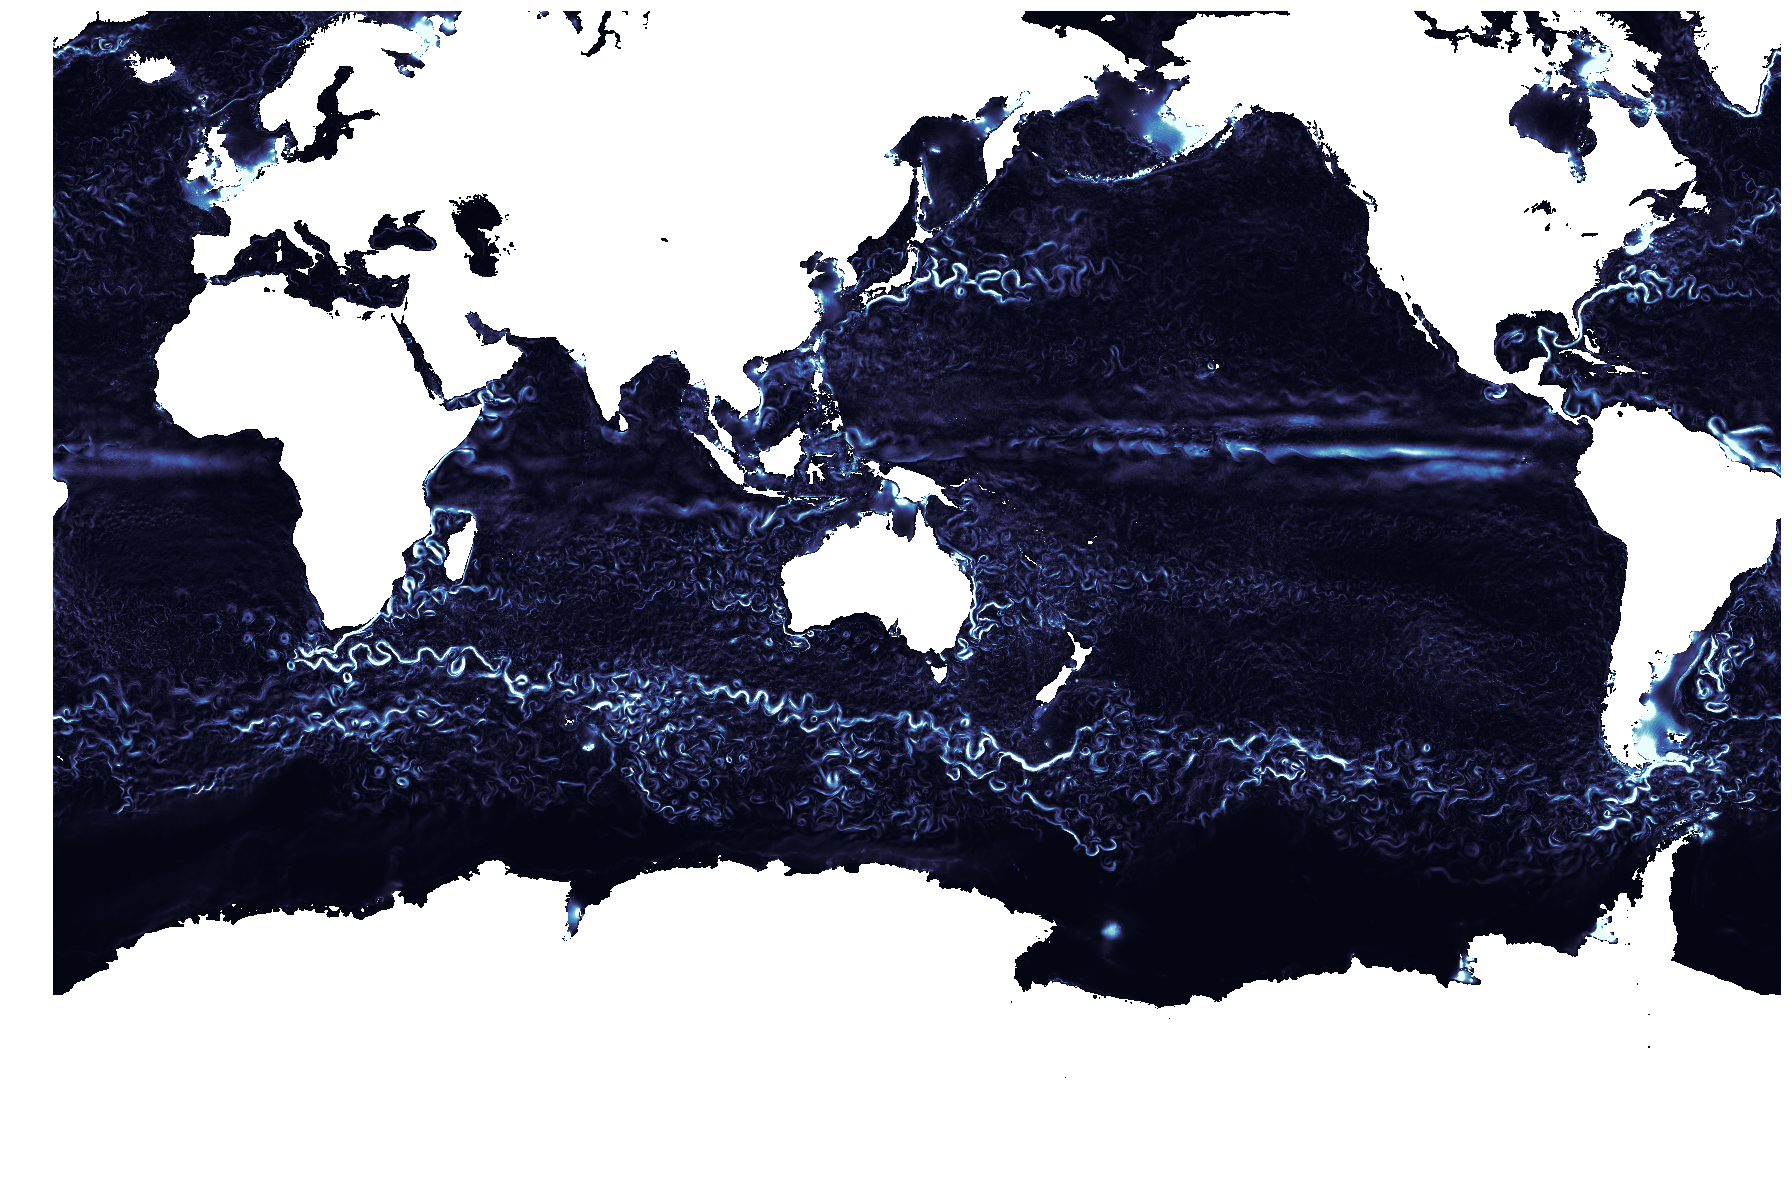

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.10:52837 remote=tcp://10.148.1.10:43165>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.10:52838 remote=tcp://10.148.1.10:43165>


In [10]:
quick_llc_plot(KE_tmean, vmin=0, vmax=1, add_colorbar=False, axis_off=True, cmap = cm.ice)

In [15]:
face_plot = 4

fig = plt.figure(figsize = (16,12))
mKE.KE_tmean.isel(face= face_plot).plot(vmin=0, vmax=1, cmap = cm.ice)

In [16]:
KE_face = mKE.KE_tmean.isel(face= 10)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
KE_face.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=1, cmap = cm.ice)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

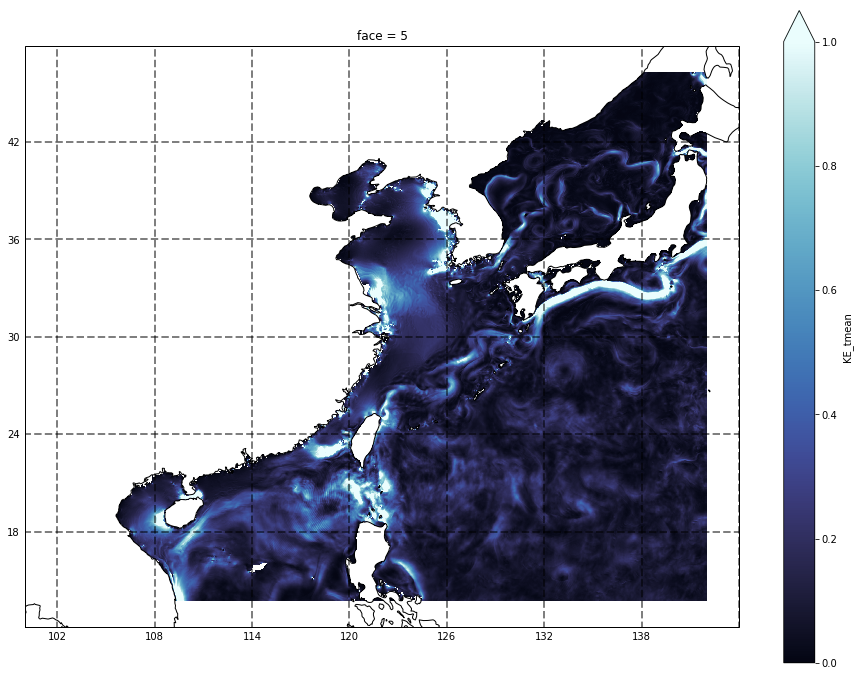

In [21]:
KE_face = mKE.KE_tmean.isel(face= 5, i=slice(2400,4320), j=slice(0,2000))

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
KE_face.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=1, cmap = cm.ice)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

In [18]:
KE_face = mKE.KE_tmean.isel(face= 1)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
KE_face.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=1, cmap = cm.ice)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

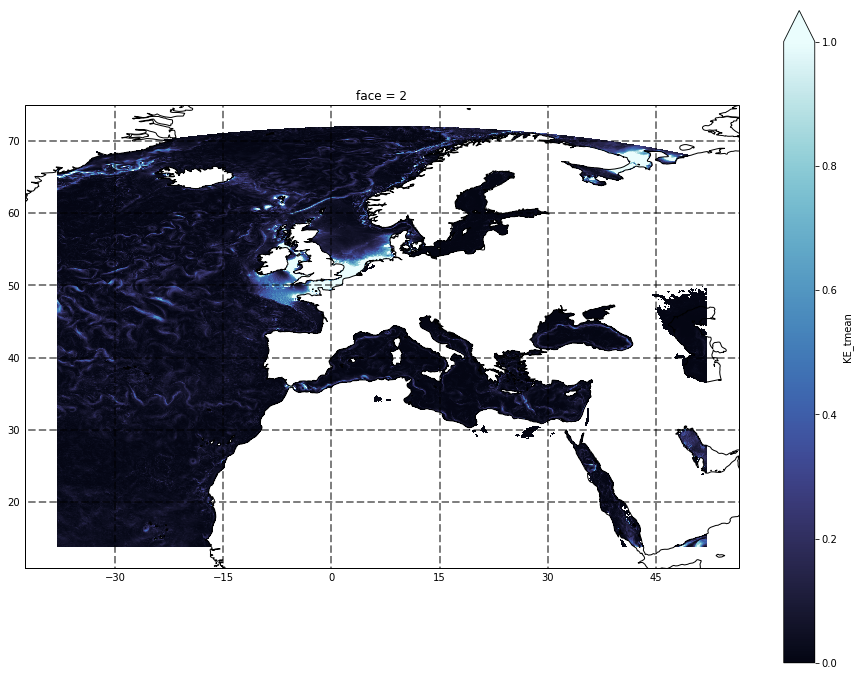

In [19]:
KE_face = mKE.KE_tmean.isel(face= 2)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
KE_face.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=1, cmap = cm.ice)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

In [20]:
KE_face = mKE.KE_tmean.isel(face= 11)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
KE_face.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=1, cmap = cm.ice)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

In [ ]:
cluster.scheduler.close()